In [4]:
ls

FIFA 2018 Statistics.csv  algo.ipynb


In [5]:
cd Documents/UM/22_23/Project 2/code

[Errno 2] No such file or directory: 'Documents/UM/22_23/Project 2/code'
/Users/leon/Documents/UM/22_23/Project 2/code


In [6]:
import numpy as np
import matplotlib.pyplot as plt

shape = (100, 16)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input
#print(X)


In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg.score(X, y), reg.coef_

(0.9993316174977624,
 array([0.98231329, 1.00293103, 1.01089872, 0.99780244, 1.01754801,
        1.01399901, 1.01117047, 1.0116978 , 0.97996713, 1.0128416 ,
        1.00504136, 1.01933667, 0.98243754, 0.98514289, 1.0177332 ,
        1.00559587]))

In [530]:
import itertools
import math

def divisive_shap_approx(X, y, model, beta, gamma_n, gamma_d, num_partitions):
    if X.shape[1] > np.emath.logn(beta, n):
        partitions = []
        sum_gamma_n = 0
        sum_gamma_d = 0
        for _ in range(num_partitions):
            split_S = partition(X,y)
            partitions.append(split_S)
            sum_gamma_n += value(X, y, model)
            sum_gamma_d += sum([value(Xi, yi, model) for Xi, yi in split_S])
        gamma_n = gamma_n * (sum_gamma_n / num_partitions)
        gamma_d = gamma_d * (sum_gamma_d / num_partitions)
        return union([divisive_shap_approx(Xi, 
                                           yi, 
                                           model,
                                           beta,
                                           gamma_n, 
                                           gamma_d,
                                           num_partitions) for Xi, yi in split_S])
    else:
        shap = shapley_true(X, y, model)
        shap = shap*gamma_n/gamma_d
        return (X, y, shap)

def value(X, y, model):
    if X.size == 0:
        return 0
    else:
        reg = model.fit(X, y)
        return reg.score(X, y)
        

def findsubsets(s, n):
    return list(itertools.combinations(s, n))


def shapley_true(X, y, model):
    """Returns true shapley value of each feature (numpy array)"""
    N = X.shape[1]
    shap = np.zeros(N)
    for i in range(N):
        other_features = set(range(N))
        other_features.remove(i)
        subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
        for subset in subsets:
            coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
            shap[i] += coeff*(value(X[:,list(subset) + [i]], y, model)-value(X[:, list(subset)], y, model))
    return np.array(shap)

def partition(X, y):
    """Returns list of tuples: [(X1, Y1), (X2, Y2), ...]"""
    #N = X.shape[1]
    #return [(X[:,:N//2], y), (X[:,N//2:], y)]

    split_results = []
    X_train, X_test = train_test_split(X.T, test_size=0.5, )#random_state=42)
    return [(X_train.T, y), (X_test.T, y)]

def union(S_split):
    """Returns the union of several sets (Xi, Yi, Shapi)"""
    X = S_split[0][0]
    y = S_split[0][1]
    shap = S_split[0][2]
    for Xi, _, shapi in S_split[1:]:
        X = np.concatenate((X, Xi), axis=1)
        shap = np.concatenate((shap, shapi))
    return (X, y, shap)


In [527]:
def main(X, y, model, beta, num_partitions = 1):
    X2, y2, shap = divisive_shap_approx(X, y, model, beta, 1, 1, num_partitions)
    w = sum(shap)
    vN = value(X, y, model)
    if w != vN:
        if w == 0:
            shap = np.array([vN/X.shape[1]]*X.shape[1])
        gamma = vN/w
        shap = shap*gamma
    return (X2, y2, shap)

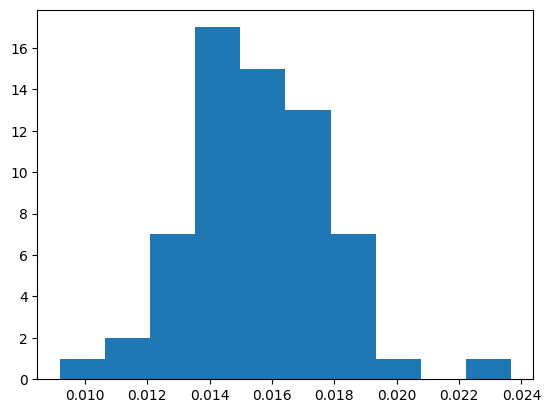

In [238]:
shape = (10000, 64)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input

X, y, shap = main(X, y, LinearRegression(), n**(1/np.sqrt(n)))

plt.hist(shap)
plt.show()


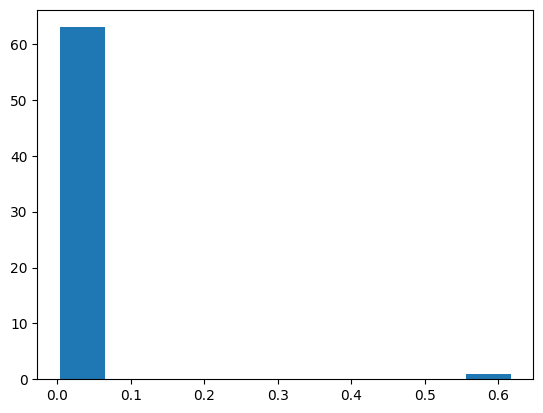

In [11]:
shape = (10000, 64)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
X[:,0] = X[:,0]*10
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input

X, y, shap = main(X, y, LinearRegression(), n**(1/np.sqrt(n)))

plt.hist(shap)
plt.show()

# Approximating Shapley Values for a real-life Dataset

In [639]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler


df = pd.read_csv('FIFA 2018 Statistics.csv')

# Select columns with dtype np.int64 or np.float64
#selected_columns = df.select_dtypes(include=[np.int64, np.int64]).columns

# Apply Min-Max scaling to the selected columns
#df[selected_columns] = MinMaxScaler().fit_transform(df[selected_columns])
#df = df.fillna(0)

y = (df['Man of the Match'] == "Yes") 
y = [1 if label == True else 0 for label in y]
feature_names = [i for i in df.columns if df[i].dtype in [np.int64, np.int64]]
X = df[feature_names]


X_norm = MinMaxScaler().fit_transform(X)
train_X, val_X, train_y, val_y = train_test_split(X_norm, y, random_state=1)
X

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
0,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,0
1,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,0
2,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,0
3,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,0
4,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1,46,11,1,6,4,4,3,24,5,79,479,148,14,1,0,0,0
124,2,43,12,4,3,5,4,1,5,5,88,510,108,11,1,0,0,0
125,0,57,15,5,7,3,5,0,12,2,92,698,110,5,2,0,0,0
126,4,39,8,6,1,1,2,1,14,1,75,271,99,14,2,0,0,0


In [155]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [690]:
from sklearn.datasets import load_boston
boston = load_boston()

X_boston = boston.data
y_boston = boston.target

train_X, val_X, train_y, val_y = train_test_split(X_boston, y_boston, random_state=42)

train_X = X_boston
val_X = X_boston
train_y = y_boston
val_y = y_boston

In [683]:
print(val_X.shape)

(506, 13)


In [701]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_X, train_y)

test_predictions = reg.predict(val_X)

# Print the correct and predicted labels side by side
#for true_label, predicted_label in zip(val_y, test_predictions):
#    print(f"True label: {true_label}, Predicted label: {predicted_label}")

reg.score(val_X, val_y), reg.coef_


(0.7406426641094095,
 array([-1.08011358e-01,  4.64204584e-02,  2.05586264e-02,  2.68673382e+00,
        -1.77666112e+01,  3.80986521e+00,  6.92224640e-04, -1.47556685e+00,
         3.06049479e-01, -1.23345939e-02, -9.52747232e-01,  9.31168327e-03,
        -5.24758378e-01]))

In [646]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression().fit(train_X, train_y)

test_predictions = log_reg.predict(val_X)

# Print the correct and predicted labels side by side
#for true_label, predicted_label in zip(val_y, test_predictions):
#    print(f"True label: {true_label}, Predicted label: {predicted_label}")

log_reg.score(val_X, val_y), reg.coef_


ValueError: ignored

### Now we introduce two functions that will use K-means clustering instead of splitting by half.

In [692]:
from sklearn.cluster import KMeans
def main2(X, y, model, beta,k):
    X2, y2, shap = divisive_shap_approx_knn(X, y, model, beta, 1, 1,k)
    w = sum(shap)
    vN = value(X, y, model)
    if w != vN:
        if w == 0:
            shap = np.array([vN/X.shape[1]]*X.shape[1])
        gamma = vN/w
        shap = shap*gamma
    return (X2, y2, shap)
def divisive_shap_approx_knn(X, y, model, beta, gamma_n, gamma_d,k):
    if X.shape[1] > max(np.emath.logn(beta, n), k):
        split_S = partition_knn(X,y,k)
        gamma_n = gamma_n*value(X, y, model)
        gamma_d = gamma_d*sum([value(Xi, yi, model) for Xi, yi in split_S])
        return union([divisive_shap_approx_knn(Xi, 
                                           yi, 
                                           model,
                                           beta,
                                           gamma_n, 
                                           gamma_d,k) for Xi, yi in split_S])
    else:
        shap = shapley_true(X, y, model)
        shap = shap*gamma_n/gamma_d
        return (X, y, shap)
def partition_knn(X,y,k):

    transposed_X = X.T

    kmeans = KMeans(
        init="random",
        n_clusters=k,
        n_init=10,
        max_iter=300,
        #random_state=42
    )
    kmeans.fit(transposed_X)
    labels = kmeans.labels_
    X = transposed_X.T
    partitions = []
    X = pd.DataFrame(X)
    for i in range(k):
        partitions.append((np.array(X.iloc[:,labels == i]),y))
      
    return partitions     

Now we calculate exact Shapley values to calculate Mean-Squared Error(MSE) and Root-Mean Squared Error(RMSE)


In [693]:
from tqdm import tqdm

N = X_boston.shape[1]
shap = np.zeros(N)
for i in tqdm(range(N)):
    other_features = set(range(N))
    other_features.remove(i)
    subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
    for subset in subsets:
        coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
        shap[i] += coeff*(value(X_boston[:,list(subset) + [i]], y_boston, reg)-value(X_boston[:, list(subset)], y_boston, reg))
true_shapley_boston = np.array(shap)
print(true_shapley_boston)

100%|███████████████████████████████████████████| 13/13 [01:01<00:00,  4.73s/it]

[0.02717564 0.02481086 0.03778189 0.01584259 0.03341462 0.18708535
 0.02203524 0.03027707 0.02362935 0.03678939 0.07852551 0.0229129
 0.20036224]


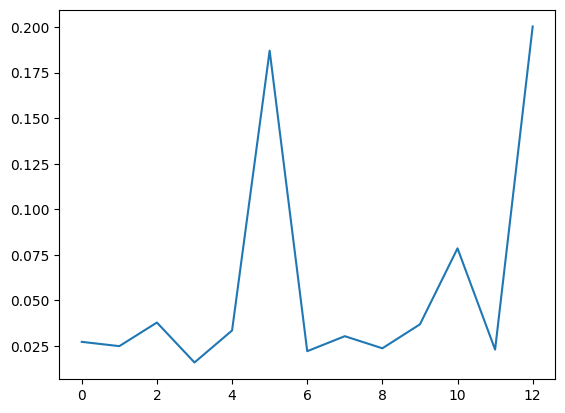

In [697]:
plt.plot(true_shapley_boston)

In [55]:
true_shapley = [0.16999648, 0.00351305, 0.01231289, 0.03640622, 0.0052994,  0.02015739, 0.01889732, 0.0034261,  0.00753081, 0.00282818, 0.00419999, 0.00374287, 0.00380925, 0.00176043, 0.01024351, 0.00525661, 0.01237468, 0.01605793]

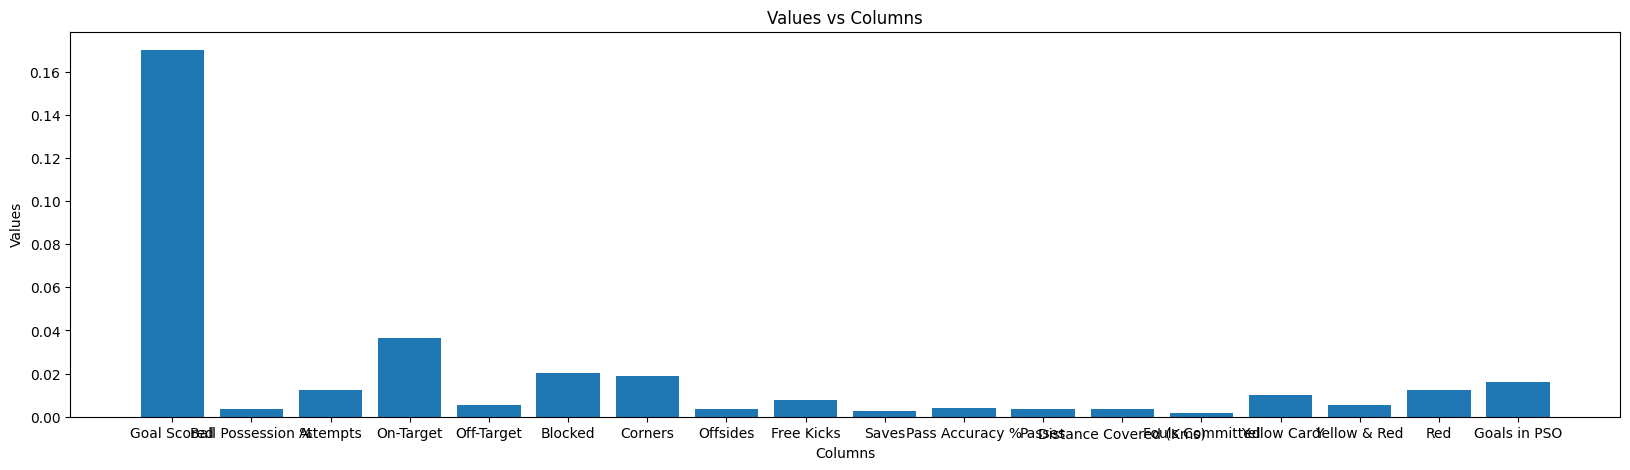

In [162]:


# Plotting
plt.figure(figsize=(20, 5))  # Adjust the figure size as desired
plt.bar(X.columns, true_shapley)
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Values vs Columns')
plt.show()


[0.13901286 0.02701046 0.1246093  0.03011923 0.02885024 0.04320077
 0.01000441 0.0822808  0.06723606 0.08203653 0.01545735 0.04136391
 0.04946075]
0.07588761970536505
0.5128507500235462


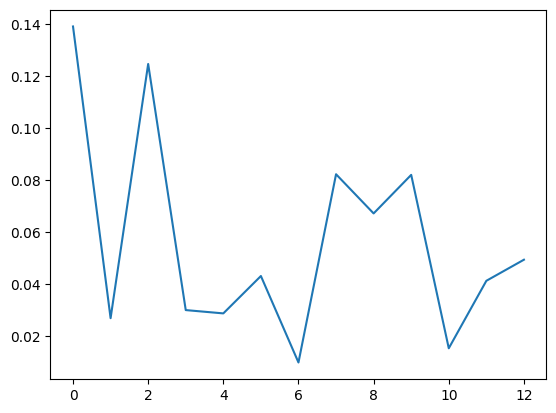

In [705]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

n = train_X.shape[1]
X2, y2, shap = main(np.array(train_X), np.array(train_y), reg, n**(1/np.sqrt(n)), 100)
# Compute the RMSE
print(shap)
mse = mean_squared_error(true_shapley_boston, shap)
rmse = np.sqrt(mse)
print(rmse)
cosine_sim = cosine_similarity([true_shapley_boston], [shap])[0][0]
print(cosine_sim)
plt.plot(shap)

[0.09100129 0.04193242 0.04026647 0.00800301 0.0395771  0.09526942
 0.0077397  0.02787177 0.01478978 0.11607101 0.07489626 0.13306792
 0.05015651]
0.06456097940004539
0.6536440607170853


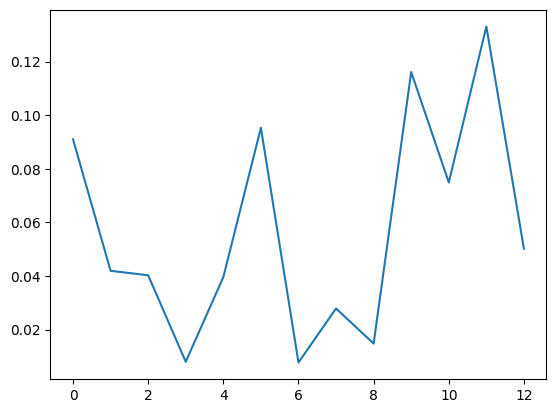

In [707]:

n = train_X.shape[1]
X2, y2, shap_knn = main2(np.array(train_X), np.array(train_y), reg, n**(1/np.sqrt(n)),2)
print(shap_knn)
mse_knn = mean_squared_error(true_shapley_boston, shap_knn)
rmse_knn = np.sqrt(mse_knn)
print(rmse_knn)

cosine_sim = cosine_similarity([true_shapley_boston], [shap_knn])[0][0]
print(cosine_sim)
plt.plot(shap_knn)

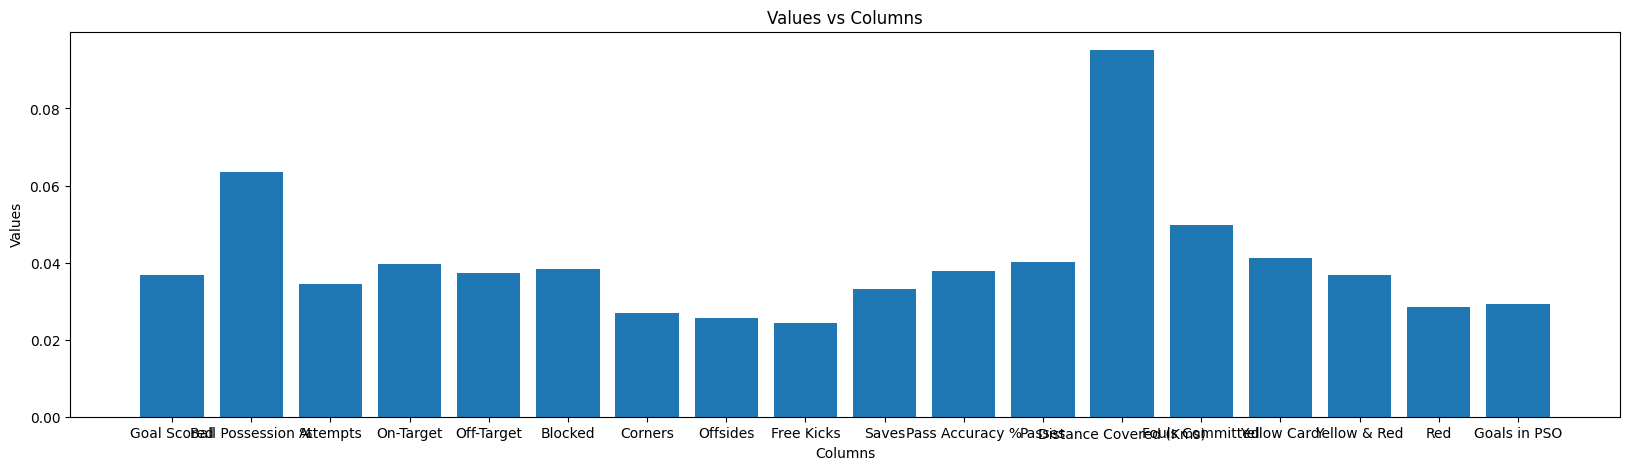

In [643]:
# Plotting
plt.figure(figsize=(20, 5))  # Adjust the figure size as desired
plt.bar(X.columns, shap)
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Values vs Columns')
plt.show()

0.04191451130624823
0.518297858068066
0.04156953821656698
0.5386761991698839
0.04540646515840785
0.43244728551807754
0.04223478612574561
0.4785029096867243
0.04378257495795685
0.48615009599381587
0.036794651895431546
0.6448562973862386
0.05319967163404841
0.2878708299632804
0.049130068670364034
0.3521366322083803
0.04947112918064976
0.3464032431490967
0.050149271411268
0.3255666234732138
0.049721133297770316
0.32082474956183965
0.043281598992132526
0.4795715039090665
0.04329754588926447
0.4661375642107998
0.04379572848904339
0.45443412842284564
0.0433080680202424
0.45612032102332345
0.043988352574474
0.43480013369292037


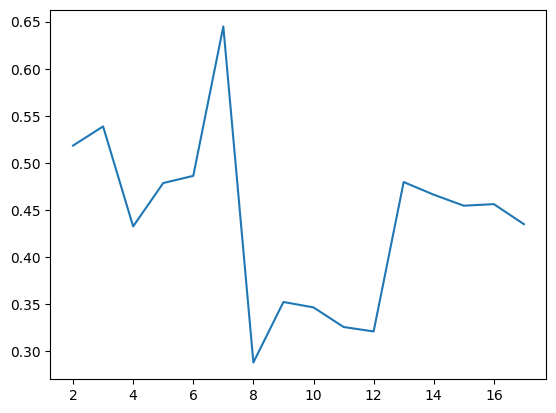

In [237]:
import matplotlib.pyplot as pl 
k_vals = []
rmse_vals = []
sim_vals = []
for i in range(2,18):
    X2, y2, shap_knn = main2(np.array(train_X), np.array(train_y), log_reg, n**(1/np.sqrt(n)),i)
    mse_knn_test = mean_squared_error(true_shapley, shap_knn)
    rmse_knn_test = np.sqrt(mse_knn_test)
    k_vals.append(i)
    rmse_vals.append(rmse_knn_test)
    print(rmse_knn_test)
    cosine_sim = cosine_similarity([true_shapley], [shap_knn])[0][0]
    sim_vals.append(cosine_sim)
    print(cosine_sim)

pl.plot(k_vals,sim_vals)


In [621]:
shape = (10000, 12)
n = shape[1]

#np.random.seed(1501)
X = np.random.uniform(-1,1, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row

for i in range(shape[1]):
    X[:,i] = X[:,i]*(10**i)

X = X + np.random.normal(0, .2, shape) # Add noise to input

In [622]:
from tqdm import tqdm

N = X.shape[1]
shap = np.zeros(N)
for i in tqdm(range(N)):
    other_features = set(range(N))
    other_features.remove(i)
    subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
    for subset in subsets:
        coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
        shap[i] += coeff*(value(X[:,list(subset) + [i]], y, reg)-value(X[:, list(subset)], y, reg))
true_shapley2 = np.array(shap)
print(true_shapley2)

100%|███████████████████████████████████████████| 12/12 [01:17<00:00,  6.43s/it]

[0.07372799 0.08085109 0.08197647 0.08881009 0.0838903  0.08470378
 0.08586951 0.08522316 0.08399962 0.07807525 0.0824164  0.08147165]


In [623]:

X1, y1, shap = main(X, y, LinearRegression(), n**(1/np.sqrt(n)), 100)
X2, y2, shap_knn = main2(X, y, LinearRegression(), n**(1/np.sqrt(n)), 8)


print('shap', cosine_similarity([true_shapley2], [shap])[0][0])
print('shap_knn', cosine_similarity([true_shapley2], [shap_knn])[0][0])


shap 0.9961583895349428
shap_knn 0.9957813382356746


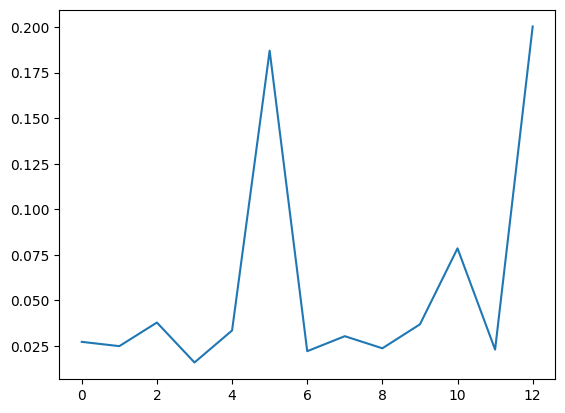

In [704]:
plt.plot(true_shapley_boston)

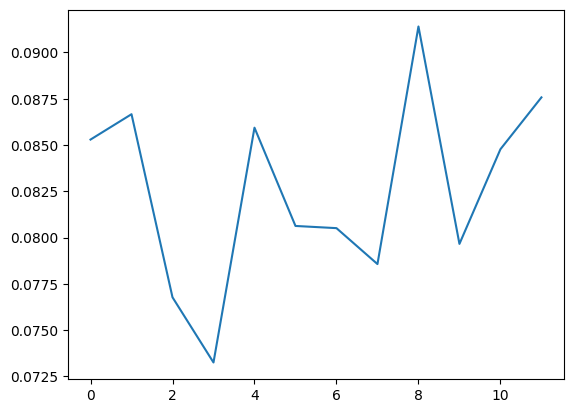

In [625]:
plt.plot(shap)

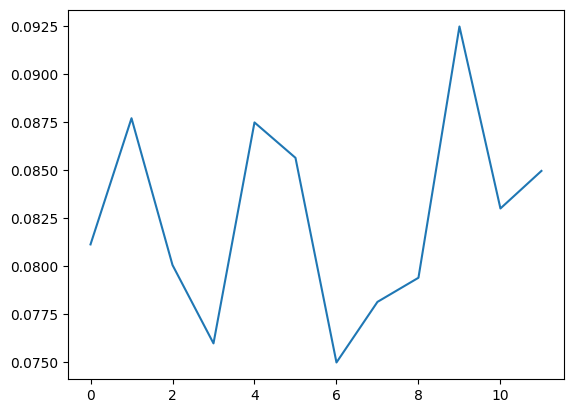

In [626]:
plt.plot(shap_knn)